`pip install acspype`

# OOI IFCB and ACS JupyterHub Example
In this example, we will sift through the CP10CNSM PLIMS (IFCB) recovered data and select an arbitrary IFCB sample to display images from.

An IFCB sample consists of 3 files (.hdr, .adc, .roi). The .hdr file provides engineering information and defines the structure of the .acd file. The .acd file provides metadata from the roi images that accompany each sample and allows for parsing of the .roi file. The .roi file contains a flat bytes stream that can be converted to images if you know the start byte and the size of the region of interest.

You can also think of an IFCB "sample" as the number of collections that occur in the time it takes for the IFCB to collect data on a single syringe.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
from PIL import Image
import xarray as xr
import yaml
import glob
import os

## IFCB Helper Functions

In [2]:
def find_plims_files(site: str, deployment_type: str = 'R') -> dict:
    """
    Find .hdr, .adc, and .roi files associated with a site deployment.

    :param site: An 8-character designator for the OOI site.
    :param deployment_type: An indicator of whether or not to look in recovered (R) or telemetered (D) datasets.
    :return: A dictionary where the key is the basename of the IFCB sample and the value is a dictionary containing filepaths to the matching files.
    """
    
    __user_dir = os.path.expanduser('~')
    uncabled_dir = os.path.join(__user_dir, 'ooi/uncabled/')
    site_dir = os.path.join(uncabled_dir, site)
    roi_files = glob.glob(os.path.join(site_dir, f'**/*{deployment_type.upper()}*/**/cg_data/**/*.roi'), recursive = True)
    adc_files = glob.glob(os.path.join(site_dir, f'**/*{deployment_type.upper()}*/**/cg_data/**/*.adc'), recursive = True)
    hdr_files = glob.glob(os.path.join(site_dir, f'**/*{deployment_type.upper()}*/**/cg_data/**/*.hdr'), recursive = True)
    
    files = {}
    for roi_file in roi_files:
        basename, _ = os.path.splitext(os.path.basename(roi_file))
        
        matching_adc = [f for f in adc_files if basename in f]
        if len(matching_adc) == 1:
            matching_adc = matching_adc[0]
        else:
            msg = f'No adc files or multiple files returned for {basename}.'
            raise ValueError
        matching_hdr = [f for f in hdr_files if basename in f]
        
        if len(matching_hdr) == 1:
            matching_hdr = matching_hdr[0]
        else:
            msg = f'No hdr files or multiple files returned for {basename}.'
            raise ValueError
            
        files[basename] = {'roi': roi_file,
                           'hdr': matching_hdr,
                           'adc': matching_adc}

    files = dict(sorted(files.items()))
    return files


def extract_sample_info(name:str) -> tuple:
    """
    Determine the sample time and serial number for the base filename.

    :param name: The base filename extracted from a filepath.
    :return: The datetime of the sample as a Pythonic datetime object and the serial number.
        In the form of a tuple (dt, sn).
    """
    dt_str, sn = name.split('_')
    dt = datetime.strptime(dt_str, 'D%Y%m%dT%H%M%S')
    return (dt, sn)


def load_roi(roi_filepath: str) -> bytes:
    """
    Load a .roi file. The .roi file contains data for multiple ROIs.

    :param roi_filepath: The absolute filepath of the .roi file.
    :return: The data in the .roi file, as bytes.
    """
    
    with open(roi_filepath, 'rb') as _file:
        rfb = _file.read()
    return rfb


def load_hdr(hdr_filepath: str) -> dict:
    """
    Load an IFCB .hdr file as a dictionary. 
    There is no guarantee that .hdr files will remain YAML files in the future

    :param hdr_filepath: The absolute filepath of the .hdr file.
    :return: Contents of the .hdr file as a dictionary.
    """
    
    with open(hdr_filepath,'r') as _file:
        hdr_data = yaml.safe_load(_file)
    return hdr_data


def load_adc(name: str, adc_filepath: str, hdr_filepath :str) -> xr.Dataset:
    """
    Load an IFCB .adc file as an xarray.Dataset.

    :param name: The basename of the roi file.
    :param adc_filepath: The absolute filepath of the .adc file.
    :param hdr_filepath: The absolute filepath of the .hdr file. The adc format is determined by
        the .hdr file. Other values arr assigned as attributes.
    :return: adc data as an xarray.Dataset.
    """

    dt, sn = extract_sample_info(name)
    
    hdr = load_hdr(hdr_filepath)

    adc_format = hdr['ADCFileFormat']    
    adc_format = adc_format.split(',')
    adc_format = [col.replace('#','') for col in adc_format] # Replace any hashes.
    adc_format = [col.replace(' ','') for col in adc_format] # Remove any spaces in column names.

    _df = pd.read_csv(adc_filepath, names = adc_format)

    adc = _df.to_xarray()

    adc = adc.rename({'trigger': 'trigger_number',
                      'ADCtime': 'adc_time',
                      'PMTA':'pmt_a',
                      'PMTB':'pmt_b',
                     'PMTC':'pmt_c',
                     'PMTD':'pmt_d',
                     'PeakA':'peak_a',
                     'PeakB': 'peak_b',
                     'PeakC': 'peak_c',
                     'PeakD': 'peak_d',
                     'TimeOfFlight':'time_of_flight',
                     'GrabTimeStart': 'grab_time_start',
                     'GrabTimeEnd': 'grab_time_end',
                     'RoiX': 'roi_x',
                     'RoiY': 'roi_y',
                     'RoiWidth': 'roi_width',
                     'RoiHeight': 'roi_height',
                     'StartByte': 'start_byte',
                     'ComparatorOut': 'comparator_out',
                     'StartPoint': 'start_point',
                     'SignalLength': 'signal_length',
                     'Status': 'status',
                     'RunTime': 'run_time',
                     'InhibitTime': 'inhibit_time'})

    adc['trigger_number'].attrs['description'] = 'Trigger number of the acquired data in sequence.'
    adc['trigger_number'].attrs['units'] = 'Not Applicable'

    adc['adc_time'].attrs['description'] = 'Elapsed time, in seconds, from the start of the sample run to the current trigger.'
    adc['adc_time'].attrs['units'] = 'seconds'

    pmts = ['pmt_a','pmt_b','pmt_c','pmt_d']
    peaks = ['peak_a','peak_b','peak_c','peak_d']
    
    for pmt in pmts:
        idx = pmts.index(pmt)
        peak = peaks[idx]
        
        adc[pmt].attrs['description'] = f'Integrated output, in volts, of the {pmt.upper()} for the current trigger pulse.'
        adc[pmt].attrs['units'] = 'volts'
        
        adc[peak].attrs['description'] = f'Peak output, in volts, of the {pmt.upper()} for the current trigger pulse.'
        adc[peak].attrs['units'] = 'volts'
        
    adc['time_of_flight'].attrs['description'] = 'Duration, in us, of the entire pulse for which a trigger signal is generated.'
    adc['time_of_flight'].attrs['units'] = 'microseconds'

    adc['grab_time_start'].attrs['description'] = 'Elapsed time, in seconds, from the start of the sample run to the current trigger. This is the same as adc_time.'
    adc['grab_time_start'].attrs['units'] = 'seconds'

    adc['grab_time_end'].attrs['description'] = 'Elapsed time, in seconds, from the start of teh sample run to the completion of the image acquisition for the current trigger.'
    adc['grab_time_end'].attrs['units'] = 'seconds'

    adc['roi_x'].attrs['description'] = 'The x position of the upper left corner of the bounding box for the current image.'
    adc['roi_x'].attrs['units'] = 'pixels'

    adc['roi_y'].attrs['description'] = 'The y position of the upper left corner of the bounding box for the current image.'
    adc['roi_y'].attrs['units'] = 'pixels'

    adc['roi_width'].attrs['description'] = 'The width, in pixels of the bounding box for the current image..'
    adc['roi_width'].attrs['units'] = 'pixels'

    adc['roi_height'].attrs['description'] = 'The height, in pixels of the bounding box for the current image..'
    adc['roi_height'].attrs['units'] = 'pixels'

    adc['start_byte'].attrs['description'] = "The integer value for the offset in the ROI array for current image."
    adc['start_byte'].attrs['units'] = 'Not Applicable'

    adc['status'].attrs['description'] = "Status flag for the state of the ROI array."
    adc['status'].attrs['units'] = 'Not Applicable'

    adc['run_time'].attrs['description'] = "Accumulated time, in seconds, for which samples has been analyzed."
    adc['run_time'].attrs['units'] = 'seconds'
    
    adc['inhibit_time'].attrs['description'] = "Accumulated time, in seconds, for which samples has not been analyzed."
    adc['inhibit_time'].attrs['units'] = 'seconds'
    
    adc = adc.drop_vars(['comparator_out','start_point','signal_length'], errors = 'ignore') # Drop placeholders.

    adc['time'] = (['index'], dt + pd.to_timedelta(adc.adc_time.values, unit = 's')) # Assign timestamp.

    # Assign dataset level attributes.
    for k, v in hdr.items():
        adc.attrs[k] = str(v)

    adc.attrs['serial_number'] = sn
    adc.attrs['start_time'] = dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    return adc


def subset_roi(start_byte_index: int | xr.DataArray, 
               roi_width:  int | xr.DataArray, 
               roi_height:  int | xr.DataArray, 
               file_bytes: bytes) -> bytes:
    """
    Subset an roi file for a specific roi defined by the start byte, width, and height of the roi for an object.

    :param start_byte_index: The starting position of the roi packet.
    :param roi_width: The width of the region of interest.  Used to compute the length of the roi packet.
    :param roi_height: The height of the region of interest. Used to compute the length of the roi packet.
    :return: The specific bytes that make up a region of interest image.
    """
    
    roi_byte_length = int(roi_width) * int(roi_height)
    roi_bytes = file_bytes[int(start_byte_index): int(start_byte_index) + roi_byte_length]
    return roi_bytes

def split_roi(roi_filepath: str, adc: xr.Dataset) -> xr.DataArray:
    """
    Split a single .roi file into roi packets that are then assigned to the corresponding adc index.

    :param roi_filepath: The absolute filepath of the .roi file.
    :param adc: A processed adc dataset created through the load_adc() function.
    :return: An xarray.DataArray of roi packets representing each ROI.
    """
    file_bytes = load_roi(roi_filepath)

    roi_packets = xr.apply_ufunc(subset_roi,
                                 adc.start_byte,
                                 adc.roi_width,
                                 adc.roi_height,
                                 file_bytes,
                                 vectorize = True)
    roi_packets.name = 'roi_packet'

    roi_packets.attrs['description'] = 'A subset of flattened bytes from the original roi file that represent the image defined by the roi_width and roi_height.'

    roi_packets.attrs['units'] = 'Not Applicable'
    
    return roi_packets


def packet2img(packet: xr.DataArray, roi_width: xr.DataArray, roi_height: xr.DataArray) -> Image:
    """
    Convert a roi packet into an image.

    :param packet: A single roi packet from an xarray.DataArray.
    :param roi_width: The width of the roi image.
    :param roi_height: The height of the roi image.
    :return: A PIL Image.
    """
    if isinstance(packet, xr.DataArray):
        bytes_data = packet.values
    else:
        bytes_data = packet
    _size = (int(roi_width), int(roi_height))
    img = Image.frombytes('L', _size, bytes_data)
    return img

## Find Recovered PLIMS Files for CP10CNSM

In [3]:
site = 'CP10CNSM'
deployment_type = 'R'
filesets = find_plims_files(site, deployment_type)

In [4]:
selected_filesets = {}
for basename in ['D20240417T152511_IFCB199', 'D20240612T082502_IFCB199', 'D20240718T202453_IFCB199']:
    selected_filesets[basename] = filesets[basename]

In [5]:
img_ds_list = []
for name, files in selected_filesets.items():
    hdr_filepath = files['hdr']
    adc_filepath = files['adc']
    roi_filepath = files['roi']
    adc = load_adc(name, adc_filepath, hdr_filepath)
    roi_packets = split_roi(roi_filepath, adc)
    _img_ds = xr.combine_by_coords([adc, roi_packets])
    _img_ds = _img_ds.swap_dims({'index':'time'})
    img_ds_list.append(_img_ds)
    
img_ds = xr.combine_by_coords(img_ds_list, combine_attrs = 'drop_conflicts')

# ACS

In [6]:
from acspype.tscor import ACSTSCor
import acspype.processing as acsproc
from acspype.utils.ooi import reformat_ooi_optaa, get_ooi_optaa_cal

In [7]:
__user_dir = os.path.expanduser('~')
acs_dir = os.path.join(__user_dir,'ooi/kdata/CP10CNSM-RID27-01-OPTAAD000-telemetered-optaa_dj_dcl_instrument/')
acs_files = glob.glob(os.path.join(acs_dir, '*.nc'))
acs_files = [f for f in acs_files if 'ctdbp' not in f]

tscor = ACSTSCor().to_xarray()  ## Load the TSCor coefficients as an xarray dataset.

In [8]:
acs_files = [f for f in acs_files if 'deployment0001' in f]
d2_list = []
for d2_file in acs_files:
    _ds = xr.open_dataset(d2_file)
    _ds = _ds.drop_vars([v for v in _ds.data_vars if 'qartod' in v])  # WHY THE FLIP ARE THERE QARTOD VARS NOW
    _ds = reformat_ooi_optaa(_ds)
    d2_list.append(_ds)
d2ds = xr.combine_by_coords(d2_list, combine_attrs = 'drop_conflicts')
d2ds = d2ds.drop_vars(['a_m_discontinuity','c_m_discontinuity'])
d2ds = d2ds.sel(latitude = float(d2ds.latitude), longitude = float(d2ds.longitude), deployment = int(d2ds.deployment))
d2ds = d2ds.drop_duplicates(dim = 'time')
d2ds = d2ds.sel(time = img_ds.time, method = 'nearest')
d2ds = d2ds.drop_duplicates(dim = 'time')

In [9]:
# Load Device File Information
d2dev = get_ooi_optaa_cal(d2ds)

# TSCor coeffs for absorption.
psi_t_a = tscor.psi_t.sel(wavelength=d2ds.a_wavelength)
psi_s_a = tscor.psi_s_a.sel(wavelength=d2ds.a_wavelength)

# TSCor coeffs for attenuation.
psi_t_c = tscor.psi_t.sel(wavelength=d2ds.c_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength=d2ds.c_wavelength)

In [10]:
d2ds['internal_temperature'] = acsproc.compute_internal_temperature(counts = d2ds.raw_internal_temperature)
d2ds['a_uncorrected'] = acsproc.compute_uncorrected(signal_counts=d2ds.a_signal, 
                                                   reference_counts = d2ds.a_reference, 
                                                   path_length=d2dev.path_length)

d2ds['c_uncorrected'] = acsproc.compute_uncorrected(signal_counts=d2ds.c_signal, 
                                                   reference_counts=d2ds.c_reference, 
                                                   path_length =d2dev.path_length)

In [11]:
d2ds['a_m_discontinuity'] = acsproc.compute_measured(uncorrected = d2ds.a_uncorrected, 
                                                    internal_temperature = d2ds.internal_temperature, 
                                                    offset = d2dev.a_offset, 
                                                    func_delta_t = d2dev.func_a_delta_t)


d2ds['c_m_discontinuity'] = acsproc.compute_measured(uncorrected = d2ds.c_uncorrected, 
                                                    internal_temperature = d2ds.internal_temperature, 
                                                    offset = d2dev.c_offset, 
                                                    func_delta_t=d2dev.func_c_delta_t)


In [12]:
discontinuity_index = acsproc.find_discontinuity_index(a_wavelength = d2ds.a_wavelength, 
                                                       c_wavelength = d2ds.c_wavelength)
d2ds['a_m'], d2ds['a_discontinuity_offset'] = acsproc.discontinuity_correction(measured = d2ds.a_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='a_wavelength')
d2ds['c_m'], d2ds['c_discontinuity_offset'] = acsproc.discontinuity_correction(measured = d2ds.c_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='c_wavelength')

In [13]:
tcal = d2dev.tcal  # The reference temperature value in the device file.

d2ds['a_mts'] = acsproc.ts_correction(measured = d2ds.a_m, 
                                     temperature = d2ds.sea_water_temperature,
                                     salinity = d2ds.sea_water_practical_salinity, 
                                     psi_temperature = psi_t_a, 
                                     psi_salinity= psi_s_a, 
                                     tcal = tcal)
d2ds['c_mts'] = acsproc.ts_correction(measured = d2ds.c_m, 
                                     temperature = d2ds.sea_water_temperature,
                                     salinity = d2ds.sea_water_practical_salinity, 
                                     psi_temperature= psi_t_c, 
                                     psi_salinity = psi_s_c, 
                                     tcal = tcal)


In [14]:
d2ds['a_mts'] = acsproc.zero_shift_correction(mts = d2ds.a_mts)
d2ds['c_mts'] = acsproc.zero_shift_correction(mts = d2ds.c_mts)

In [15]:
d2dsi = acsproc.interpolate_common_wavelengths(ds = d2ds, 
                                             a_wavelength_dim='a_wavelength',
                                             c_wavelength_dim='c_wavelength',
                                             new_wavelength_dim='wavelength',
                                             step=1,
                                             wavelength_range='infer')

In [16]:
reference_wavelength = 715
d2dsi = d2dsi.sel(wavelength = slice(None, reference_wavelength))
a_mts_715 = d2dsi.a_mts.sel(wavelength = reference_wavelength, method = 'nearest')
c_mts_715 = d2dsi.c_mts.sel(wavelength = reference_wavelength, method = 'nearest')

In [17]:
d2dsi['a_mts_proportional'] = acsproc.proportional_scattering_correction(a_mts = d2dsi.a_mts, 
                                                                       c_mts = d2dsi.c_mts, 
                                                                       reference_a = a_mts_715, 
                                                                       reference_c = c_mts_715) # Proportional Method from Zaneveld et al. 1994
d2dsi['a_mts_proportional'] = acsproc.zero_shift_correction(mts = d2dsi.a_mts_proportional)


# PLIMS and ACS Data

In [18]:
img_ds1 = img_ds.sel(time = slice(None, datetime(2024,5,1)))
img_ds1 = img_ds1.swap_dims({'time': 'index'})

img_ds2 = img_ds.sel(time = slice(datetime(2024,5,1), datetime(2024,6,20)))
img_ds2 = img_ds2.swap_dims({'time': 'index'})

img_ds3 = img_ds.sel(time = slice(datetime(2024,6,20),None))
img_ds3 = img_ds3.swap_dims({'time': 'index'})

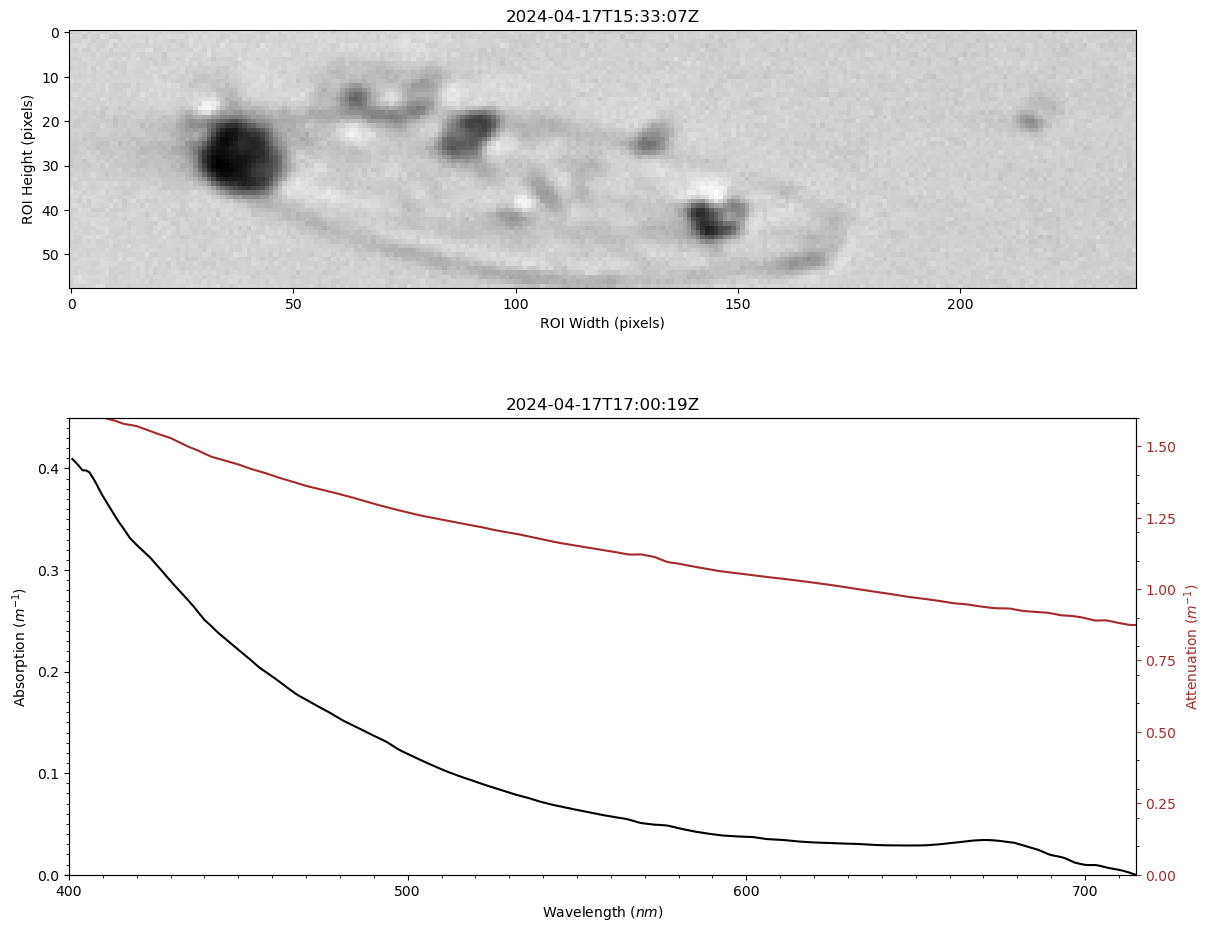

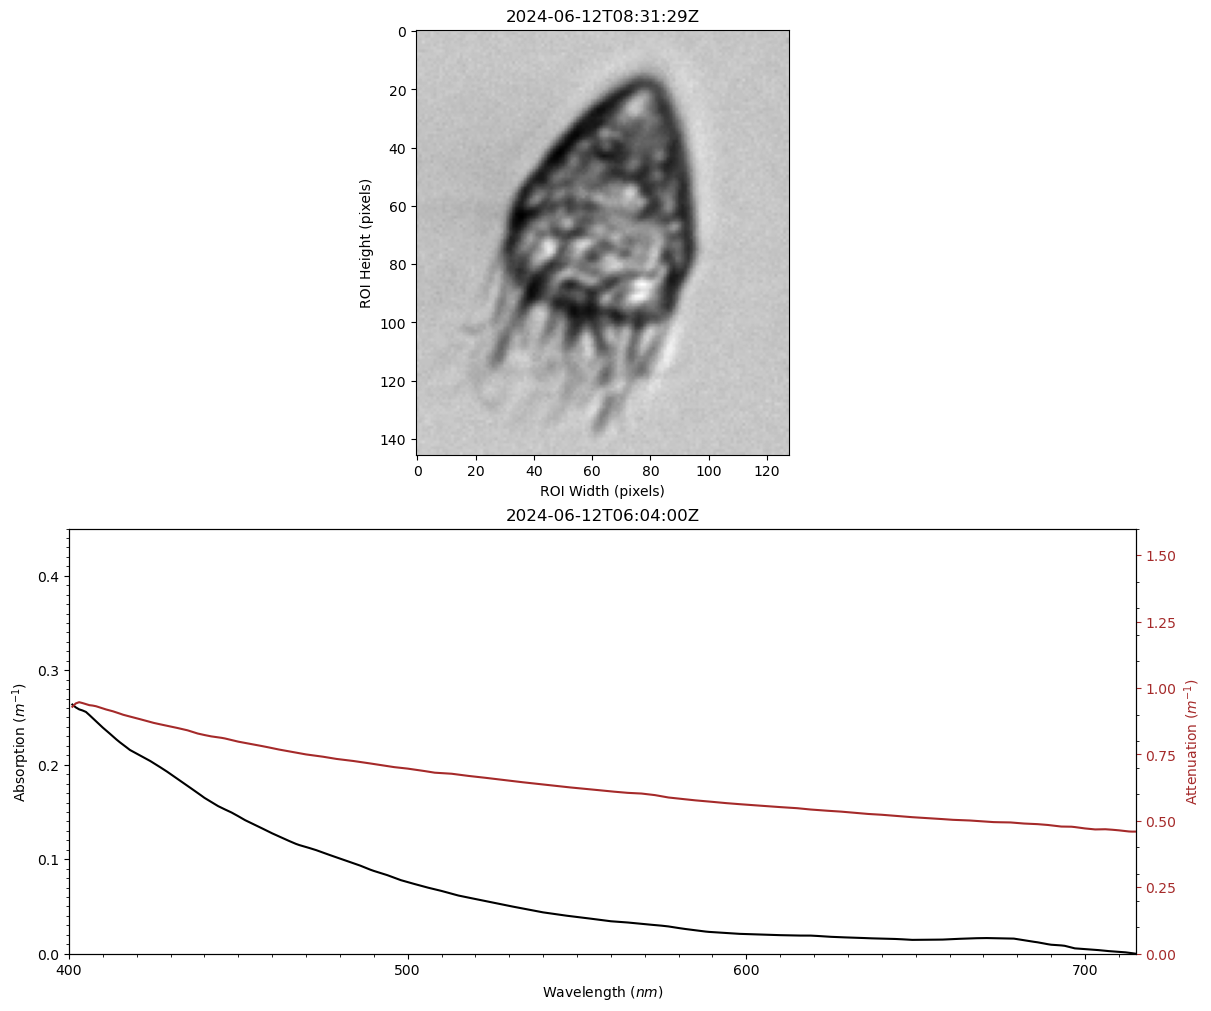

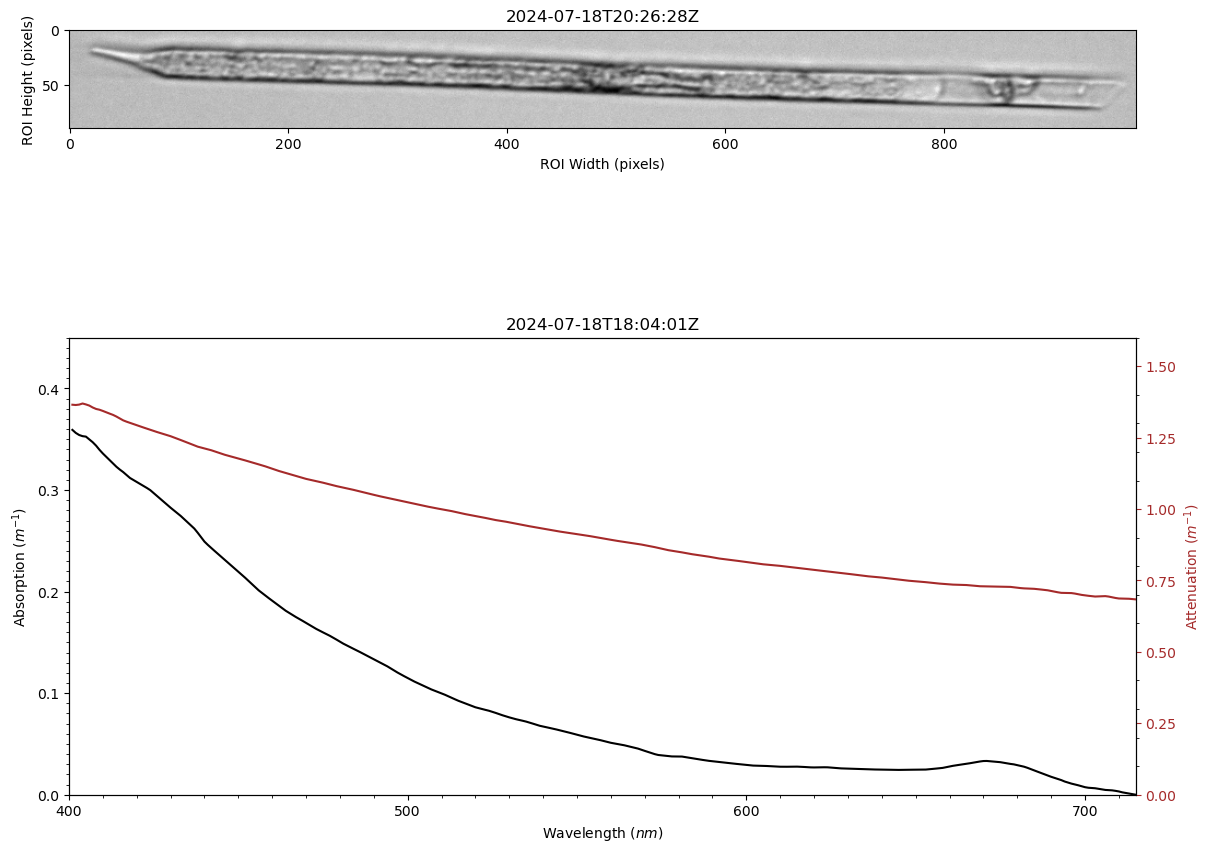

In [19]:
i1 = img_ds1.sel(index = 1800)
i2 = img_ds2.sel(index = 209)
i3 = img_ds3.sel(index = 236)

for i in [i1,i2,i3]:
    fig, ax = plt.subplots(2,1,constrained_layout = True, figsize = (12,10))


    img = packet2img(i.roi_packet, i.roi_width, i.roi_height)


    nearest_acs_spectra = d2dsi.sel(time = i.time, method = 'nearest')


    ax[0].imshow(img, cmap = 'gray')
    ax[0].set_title(i.time.dt.strftime('%Y-%m-%dT%H:%M:%SZ').values)
    ax[0].set_xlabel('ROI Width (pixels)')
    ax[0].set_ylabel('ROI Height (pixels)')

    
    ax[1].plot(nearest_acs_spectra.wavelength, nearest_acs_spectra.a_mts_proportional, color = 'black', label = 'Absorption')
    ax2 = ax[1].twinx()
    ax2.plot(nearest_acs_spectra.wavelength, nearest_acs_spectra.c_mts, color ='brown', label = 'Attenuation')
    ax2.yaxis.label.set_color('brown')
    ax2.tick_params(axis='y', colors='brown')
    ax[1].set_title(nearest_acs_spectra.time.dt.strftime('%Y-%m-%dT%H:%M:%SZ').values)
    ax[1].set_ylabel(r'Absorption ($m^{-1}$)') 
    ax[1].set_xlabel(r'Wavelength ($nm$)') 
    ax2.set_ylabel(r'Attenuation ($m^{-1}$)')

    ax[1].set_ylim(0, 0.45)
    ax[1].set_xlim(400,715)
    ax2.set_ylim(0, 1.6)
    ax2.set_xlim(400,715)

    
    ax[1].xaxis.set_major_locator(MultipleLocator(100))
    ax[1].xaxis.set_minor_locator(MultipleLocator(10))
    
    ax[1].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
    ax2.yaxis.set_major_locator(MultipleLocator(0.25))
    ax2.yaxis.set_minor_locator(MultipleLocator(0.1))


